In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats as spst

In [2]:
from sif.models.sigmoid import sigmoid

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

In this notebook, I will explore preconditioning of Langevin dynamics. The Langevin equation can be preconditioned and maintain the same stationary distribution through the following modification.
\begin{align}
\mathop{d}\theta_t = -\mathbf{M}\nabla_\theta V(\theta_t) + \sqrt{2\mathbf{M}} \mathop{d}B_t
\end{align}
where $\mathbf{M}$ is a preconditioning matrix. In this notebook, rather than define the potential well via numpy, I will specify the log-posterior ($V(\theta_t)$) directly in TensorFlow and exploit automatic differentiation in order to obtain the gradient ($\nabla_\theta V(\theta_t)$).

In [4]:
def inference(x_ph, n_feats, n_classes):
    if n_classes == 2:
        n_classes -= 1
    with tf.name_scope("linear"):
        weights = tf.Variable(tf.zeros([n_feats, n_classes], name='weights'))
    logits = tf.matmul(x_ph, weights)
    return logits, weights

In [5]:
def loss(labels_ph, logits, weights, l2_reg):
    if logits.get_shape()[1].value == 1:
        labels = tf.to_float(labels_ph)
        nll = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
            labels=labels, logits=tf.squeeze(logits)))
    else:
        labels = tf.to_int64(labels_ph)
        nll = tf.losses.sparse_softmax_cross_entropy(
            labels=labels, logits=logits)
    reg = l2_reg * tf.reduce_sum(tf.square(weights)) 
    return nll + reg

Define constants.

In [6]:
n_feats = 2
n_classes = 2

Define placeholders.

In [7]:
x_ph = tf.placeholder(tf.float32, [None, n_feats])
labels_ph = tf.placeholder(tf.int32, [None])

Define potential well.

In [8]:
logits, weights = inference(x_ph, n_feats, n_classes)
V = loss(labels_ph, logits, weights, 0.5)

Compute gradient of the potential well.

In [9]:
grad_V = tf.gradients(V, [weights])
opt = tf.train.GradientDescentOptimizer(learning_rate=1e-3)

In [10]:
grads_and_vars = opt.compute_gradients(V, [weights])
langevin_grads_and_vars = [
    (g + np.sqrt(2) * tf.random.normal(g.get_shape(), stddev=1/np.sqrt(opt._learning_rate)), v) 
    for g, v in grads_and_vars]
train_op = opt.apply_gradients(langevin_grads_and_vars)

With the TensorFlow computational graph defined, we can proceed to applying the usual (un-preconditioned) Langevin dynamics equation to sample from this distribution.

In [11]:
np.random.seed(0)
n = 500
x = np.random.normal(scale=2, size=(n, n_feats))
theta_star = np.array([2, -1])
y = np.random.binomial(1, sigmoid(x.dot(theta_star)))

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [29]:
n_samples = 5000
n_thin = 10
Theta = np.zeros((n_samples, n_feats))

In [30]:
sample_index = 0
for i in range(n_samples*n_thin):
    sess.run(train_op, {x_ph: x, labels_ph: y})
    if (i+1) % n_thin == 0:
        Theta[sample_index] = sess.run(weights).ravel()
        sample_index += 1

In [31]:
kernel = spst.gaussian_kde(Theta.T)
bounds_min, bounds_max = Theta.min(axis=0), Theta.max(axis=0)
n_grid = 30
Theta_1_grid, Theta_2_grid = np.meshgrid(
    np.linspace(bounds_min[0], bounds_max[0], n_grid), 
    np.linspace(bounds_min[1], bounds_max[1], n_grid))
Theta_grid = np.vstack([Theta_1_grid.ravel(), Theta_2_grid.ravel()])
f_grid = np.reshape(kernel(Theta_grid), Theta_1_grid.shape)

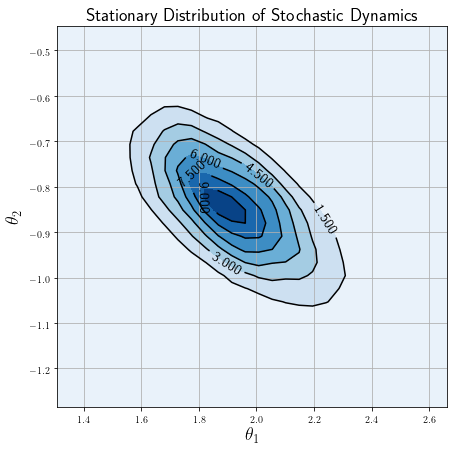

In [32]:
plt.figure(figsize=(7, 7))
plt.grid()
plt.contourf(Theta_1_grid, Theta_2_grid, f_grid, cmap='Blues')
cset = plt.contour(Theta_1_grid, Theta_2_grid, f_grid, colors="k")
plt.clabel(cset, inline=1, fontsize=14)
plt.xlabel("$\\theta_1$", fontsize=18)
plt.ylabel("$\\theta_2$", fontsize=18)
plt.title("Stationary Distribution of Stochastic Dynamics", fontsize=18)
plt.show()

In [33]:
Theta

array([[ 1.72888517, -0.67463535],
       [ 1.7779882 , -0.69420904],
       [ 1.7275157 , -0.70228869],
       ...,
       [ 2.068645  , -0.74573219],
       [ 2.02805161, -0.8651185 ],
       [ 1.94896173, -0.72809547]])

In [18]:
# sess.close()